## Gottesacker SWMM model
Based on Zhao Chen's Gottesacker model.
***
**Functions:**
<br>- Writes SWMM project.inp files using a template (template.inp) - searches for placeholder strings in the template and replaces them with data from a pandas dataframe. Dataframes can be created manually, or loaded from .csv files.
<br>- Run SWMM using the specified project.inp file
<br>
<br>
**Goals:**
<br>- Import results from project.rpt file as pandas dataframes
***
**Files needed:**
<br>- template.inp
<br>- swmm5.exe
<br>- swmm5.dll
<br>
<br>
**Packages needed:**
<br>- pandas
<br>- numpy
<br>- subprocess
<br>- geopandas
<br>- shapely
<br>- matplotlib
<br>- swmmtoolbox

**Notes:**
<br>- template.inp files must not have any commas in them (otherwise the importer thinks they are column breaks)
<br>- placeholders in template.inp files must not have any other characters (even spaces) in the same line
<br>- order of placeholder list and data filename list must be the same
<br>- common error: the template filename isn't correct, so the insert_data() function can't find the section where it's supposed to insert the data

In [1]:
import pandas as pd
import numpy as np
import subprocess as sb
import geopandas as gpd
from shapely import geometry as shg
from shapely import ops as sho
import shapely.speedups
import swmmpy as sp
import importlib
from swmmtoolbox import swmmtoolbox as st
import matplotlib.pyplot as plt
import sys

#Embed matplotlib figures into notebooks:
%matplotlib inline

#Disable some warnings (CAUTION!!!!!):
pd.options.mode.chained_assignment = None  #this suppresses the pandas warning that happens when you overwrite things

In [ ]:
importlib.reload(sp)

In [2]:
#File structure and naming:

exe =               'swmm5.exe'                                             #filename for swmm executable
template_filename = 'template4.inp'                                         #filename for template .inp file to import
projectname =       'gott4'                                                 #name to use when writing new .inp file, and .pt and .out files

inputfile =          projectname+'.inp'                                     #filename to write new .inp file to
reportfile =         projectname+'.rpt'                                     #filename to write .rpt file to
outputfile =         projectname+'.out'                                     #filename to write .out file to

placeholders =      ['subcatchments', 'junctions', 'outfalls', 'conduits',  #placeholder strings to search for and replace with data
                     'xsections', 'inflows', 'report', 'coordinates']                


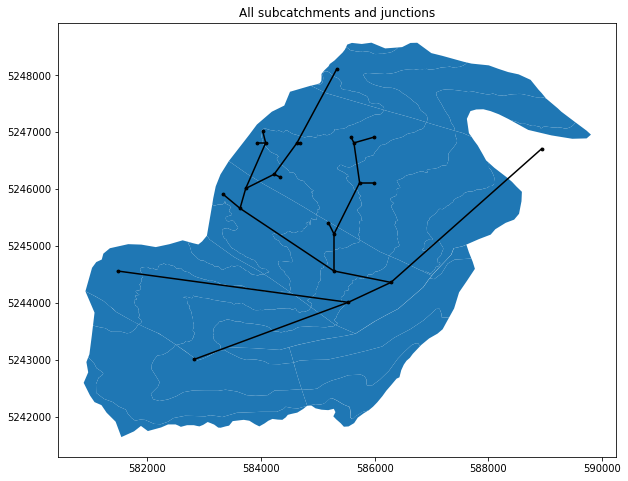

In [3]:
#Import SKS and GIS data:
plot=True  #set whether to plot results or not (True/False)

#Locate data:
poly_file    = r'C:\Users\Chloe\Desktop\PhD\GIS maps\ArcMap files\subcatchments.shp'                   #path to subcatchment shapefile
sc_data_file = 'subcatchments.csv'                                                                     #path to subcatchment data file
nodes_file   = r'C:\Users\Chloe\Desktop\PhD\SKS\gottesacker\output_SKS\output_SKS_simpleNodes.txt'     #path to SKS nodes file (simplified version)
elev_file    = r'C:\Users\Chloe\Desktop\PhD\SKS\gottesacker\output_SKS\output_SKS_simpleElevs.txt'     #path to SKS elev file
links_file   = r'C:\Users\Chloe\Desktop\PhD\SKS\gottesacker\output_SKS\output_SKS_simpleLinks.txt'     #path to SKS links file
spring_file  = r'C:\Users\Chloe\Desktop\PhD\SKS\gottesacker\output_SKS\output_SKS_springNodesXYZ.dat'  #path to SKS nodes file

#Import & format data:
polygons      = gpd.read_file(poly_file)                                            #import subcatchment shapefile
polygons.sort_values(by='typ',inplace=True)                                         #sort by subcatchment number
sc_data       = pd.read_csv(sc_data_file, header=1)                                           #import subcatchment data file

nodes         = pd.read_csv(nodes_file, header=None, names=['X','Y'], delim_whitespace=True) #import node data from SKS txt output file
nodes['Z']    = pd.read_csv(elev_file, header=None, names=['Z'])                    #import node elev data from SKS and add it as a new column
nodes['type'] = 'junction'                                                          #add a column for node type & fill with junction as default
nodes['Name'] = nodes.index                                                         #add a column for node name (based on index)
springs       = pd.read_csv(spring_file, delim_whitespace=True)                     #import spring location data
nodes.type[nodes.X==springs.X.values[0]] = 'outfall'                                #change node type to outfall for springs (based on X location)

links         = pd.read_csv(links_file, header=None, names=['InNode','OutNode'], delim_whitespace=True) #import link data from SKS txt output file (simplified)
links         = links - 1                                                           #convert node indices to Python 0-based  indices
links['InNode']  = [int(node) for node in links.InNode]                             #convert to integer
links['OutNode'] = [int(node) for node in links.OutNode]                            #convert to integer
links['dz']      = [nodes.loc[links.loc[i].InNode].Z - nodes.loc[links.loc[i].OutNode].Z for i in links.index]  #add new column for elevation change between two nodes
links = links[links.dz.values>0]                                                    #select only conduits with a downhill slope
links.reset_index(drop=True,inplace=True)                                           #reset indexing to start from zero
links['Name'] = links.index                                                         #add a column for link name (use row index)

fromX = nodes.X.loc[links.InNode]                                                   #calculate coordinates for link start and end points
fromY = nodes.Y.loc[links.InNode]
toX   = nodes.X.loc[links.OutNode]
toY   = nodes.Y.loc[links.OutNode]

#Plot entire system:    
if plot==True:
    f,ax = plt.subplots(figsize=(10,10))                                                 #create figure & axis objects
    polygons.plot(ax=ax)                                                                 #plot subcatchments
    ax.scatter(nodes.X, nodes.Y, color='k', s=8)                                         #plot nodes
    for ind in links.index:                                                              #loop over link indices
        plt.plot((fromX.iloc[ind],toX.iloc[ind]),(fromY.iloc[ind],toY.iloc[ind]), c='k') #plot links
    plt.title('All subcatchments and junctions')
    

In [7]:
#Create junctions dataframe:
junctions  = nodes[nodes.type=='junction']                              #split nodes into only junction-type nodes(not outfalls)
junctions.drop(labels=['X','Y','type'], axis='columns', inplace=True)   #drop unneeded columns
junctions.rename({'Z':'InvertElev'},    axis='columns', inplace=True)   #rename to SWMM's column names
junctions['MaxDepth']  = 0                                              #add required columns
junctions['InitDepth'] = 0
junctions['SurDepth']  = 200
junctions['Aponded']   = 0
colnames = ['Name','InvertElev','MaxDepth','InitDepth','SurDepth','Aponded']    #list of column names in the correct order
junctions = junctions.reindex(columns=colnames)                                 #reorder the column names

#Create outfalls dataframe:
outfalls = nodes[nodes.type=='outfall']                                #split nodes into only outfall-type nodes(not junctions)
outfalls.drop(labels=['X','Y','type'], axis='columns', inplace=True)   #drop unneeded columns
outfalls.rename({'Z':'InvertElev'},    axis='columns', inplace=True)   #rename to SWMM's column names
outfalls['OutType']  = 'FREE'                                          #add required columns
outfalls['Stage']    = ''
outfalls['TideGate'] = 'NO'
colnames = ['Name','InvertElev','OutType','Stage','TideGate']           #list of column names in the correct order
outfalls = outfalls.reindex(columns=colnames)                           #reorder the column names

#Create conduits dataframe:
conduits = links.copy()                                      #create a dataframe by copying links
conduits.drop(labels=['dz'], axis='columns', inplace=True)   #drop  unneeded columns
conduits['Length']    = [((toX.iloc[ind] - fromX.iloc[ind])**2 + (toY.iloc[ind] - fromY.iloc[ind])**2)**0.5 for ind in links.index]  #calculate length using distance formula and add it as a new column
conduits['ManningN']  = 0.01                                 #add other columns
conduits['InOffset']  = '*'
conduits['OutOffset'] = '*'
conduits['InitFlow']  = 0
conduits['MaxFlow']   = 0
colnames = ['Name','InNode','OutNode','Length','ManningN','InOffset','OutOffset','InitFlow','MaxFlow']  #list of column names in the correct order
conduits = conduits.reindex(columns=colnames)                                                           #reorder the column names

#Create coordinates dataframe:
coordinates = nodes.copy()                                                          #create a dataframe by copying nodes
coordinates.drop(labels=['Z','type'],              axis='columns', inplace=True)    #drop unneeded columns
coordinates.rename({'X':'X-Coord', 'Y':'Y-Coord'}, axis='columns', inplace=True)    #rename to SWMM's column names
colnames = ['Name','X-Coord','Y-Coord']                                             #list of column names in the correct order
coordinates = coordinates.reindex(columns=colnames)                                 #reorder the column names

#Create xsections dataframe:
xsections = conduits.copy()        #create a dataframe by copying nodes
xsections.drop(labels=['InNode','OutNode','Length','ManningN','InOffset','OutOffset','InitFlow','MaxFlow'], axis='columns', inplace=True)    #drop unneeded columns
xsections['Shape']   = 'FORCE_MAIN'    #set shape of conduit (see SWMM doc table D-1) - FORCE_MAIN is a circle
xsections['Geom1']   = 3.0             #set diameter in m
xsections['Geom2']   = 1000.0          #set roughness in mm
xsections['Geom3']   = 0               #not changing remaining parameters
xsections['Geom4']   = 0
xsections['Barrels'] = 1
xsections['Culvert'] = ''

#Create inflows dataframe:
#list of timeseries names to use as inflows:
timeseries = ['Baseflow16','Baseflow17','Baseflow18','Baseflow19','Baseflow20','Baseflow11','Baseflow12',
              'Baseflow13','Baseflow14','Baseflow15','Baseflow6','Baseflow7','Baseflow8','Baseflow9',
              'Baseflow10','Baseflow1','Baseflow2','Baseflow3','Baseflow4','Baseflow5']                     
inflows = nodes.iloc[:len(timeseries)].copy()                               #create a dataframe by copying the first nodes (as many as there are timeseries)
inflows.drop(labels=['Z','type','X','Y'],  axis='columns', inplace=True)    #drop unneeded columns
inflows.rename({'Name':'Node'},            axis='columns', inplace=True)    #rename to SWMM's column names
inflows['Parameter']   = 'FLOW'                                             #add needed columns
inflows['TimeSeries']  = timeseries                                         #assign timeseries from list
inflows['ParType']     = 'FLOW'              
inflows['UnitFactor']  = 1.0              
inflows['ScaleFactor'] = 1.0             
inflows['BaseVal']     = ''              
inflows['BasePattern'] = ''             
colnames = ['Node','Parameter','TimeSeries','ParType','UnitFactor','ScaleFactor','BaseVal','BasePattern']                                     #list of column names in the correct order
inflows = inflows.reindex(columns=colnames)                                 #reorder the column names

#Create report dataframe:
report = pd.DataFrame()                                                 #create empty dataframe
rnodes = str(outfalls.Name.values[0])                                   #get node name for springs
rlinks = str(conduits.Name.iloc[-5:].values)                            #get conduit names for last 5 conduits
rlinks = rlinks.replace('[','').replace(']','')                         #strip brackets from string (there is probably a prettier way of doing this)
report['Type']   = ['INPUT','CONTROLS','SUBCATCHMENTS','NODES','LINKS'] #add column for item types to report (see SWMM doc for options)
report['Option'] = ['NO',    'NO',     'NONE',         rnodes,  rlinks] #set options for each item type being reported


In [8]:
#Create subcatchments dataframe:

plot=False                          #turn plots on/off
#Create junction points using shapely, to use for spatial analysis:
jnodes = nodes[nodes.type=='junction']                              #split nodes into only junction-type nodes(not outfalls)
points = [shg.Point(jnodes.loc[i].X, jnodes.loc[i].Y, jnodes.loc[i].Z) for i in jnodes.index]    #create list of point objects by looping over points in df
jpts = jnodes                                                                     #create df for junction points starting from junction data
jpts['geometry'] = points                                                            #add a column with the points

#Loop over subcatchments to identify draining node:
outlets = pd.DataFrame()                                    #create an empty dataframe to store outlet info
nsc  = len(polygons.typ)                                    #get number of subcatchments
if plot==True:
    f,ax = plt.subplots(nsc,1, figsize=(10,nsc*5))          #create figure and axis objects

for i in range(nsc):                                        #loop over subcatchments
    sc = polygons.typ.iloc[i]                               #get subcatchment index (not the same as i)
    #print('calculating for subcatchment ', sc)
    #Get current polygon
    loc = polygons['typ']==sc                               #get location index of current subcatchment
    S = polygons.loc[loc]                                   #get current subcatchment
    poly = S.iloc[0].geometry                               #get polygon info for desired polygon
    
    #Check which points are in selected polygon:
    pip = []                                                #create empty list to store points in polygon
    for j in jpts.index:                                  #loop over point indices
        if jpts.iloc[j].geometry.within(poly):            #if the point is in the polygon
            pip.append(jpts.iloc[j])                      #add it to the list
    pip = pd.DataFrame(pip)                                 #convert to dataframe for easier manipulation

    #Plot:
    if plot==True:
        polygons.plot(ax=ax[i], facecolor='gray')           #plot the polygons
        S.plot(ax=ax[i])                                    #plot selected sub-catchment
        pts = [ax[i].scatter((p.x),(p.y),color='k', s=8) for p in jpts.geometry]          #plot all points
        if len(pip)>0:                                                                      #if there are points in the polygon
            pts = [ax[i].scatter((p.x),(p.y),color='r', s=8) for p in pip.geometry]         #plot only points in polygon
        ax[i].set_title(str(sc))
    
    #Adjust if several points in one polygon, or if none:
    if len(pip)==1:                    #if polygon holds exactly one point
        outlet = pip                   #that point is the outlet
    if len(pip)>1:                     #if polygon holds more than one point
        lowp = pip[pip.Z==min(pip.Z)]  #select lowest-elevation point from points in polygon
        outlet = lowp                  #the low point is the outlet
        if plot==True:                
            ax[i].scatter(lowp.X,lowp.Y, c='r', s=30, marker='X') 
    if len(pip)==0:                    #if polygon holds no points
        c = poly.centroid              #get centroid of polygon
        mpo = shg.MultiPoint(jpts.geometry)  #create a multi-point object for all points under consideration
        nearest_geometry = sho.nearest_points(c,mpo)[1]  #calculate the nearest point (note that nearest_points returns two objects, the centroid and the actual point)
        nearest = jpts[jpts.X==nearest_geometry.x]       #get that point from the detailed points dataframe (by checking the x and y coords)
        nearest = nearest[nearest.Y==nearest_geometry.y]
        outlet = nearest                                 #the nearest point is the outlet
        if plot==True:
            ax[i].scatter(nearest.X,nearest.Y, c='r', s=30, marker='X')
    #print('number of points in subcatchment: ', len(pip))
    outlet['subcatchment'] = sc                         #add column with subcatchment index
    outlets = outlets.append(outlet)                    #store outlet info in a dataframe

outlets.drop_duplicates(subset=['subcatchment'], keep='first',inplace=True)  #remove duplicate subcatchmets

subcatchments = pd.DataFrame()                          #create new empty dataframe
subcatchments['Name']     = ['S'+str(s) for s in outlets.subcatchment] #assign subcatchments (add an S to name to distinguish from nodes)
subcatchments['Raingage'] = outlets.subcatchment.values #assign raingages
subcatchments['Outlet']   = outlets.Name.values         #assign newly-calculated outlets
subcatchments['TotArea']  = sc_data.TotArea.values      #eventually calculate this from shapefiles
subcatchments['PctImpv']  = 0.25
subcatchments['Width']    = sc_data.TotArea.values      #eventually calculate this from shapefiles
subcatchments['PctSlope'] = 0.25
subcatchments['CurbLen']  = 0
subcatchments['SnowPack'] = ''



In [9]:
#Update subcatchments & write new input file:

data = [subcatchments, junctions, outfalls, conduits, xsections, inflows, report, coordinates] #group data dataframes into a list

#Write new input file:    
sp.write_input(inputfile, placeholders, data, template_filename=template_filename)

In [10]:
#Run SWMM with new .inp and generate .rpt and .out files   
sp.run(inputfile, reportfile, outputfile)



 o  Retrieving project data

... EPA-SWMM 5.1 (Build 5.1.13)





... EPA-SWMM completed in 30.00 seconds. There are warnings.



  WARNING 04: minimum elevation drop used for Conduit 8
  Continuity Error (%) .....         5.248
Available outflow nodes:	 ['23']
Available data types:		 ['Depth_above_invert' 'Hydraulic_head' 'Volume_stored_ponded'
 'Lateral_inflow' 'Total_inflow' 'Flow_lost_flooding']


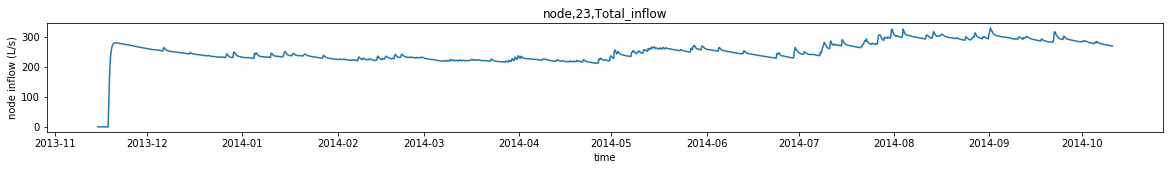

In [13]:
#Read outputs:

#Report file:
flags = ['WARNING','ERROR','Continuity Error']          #set which flags to print (any lines containing these strings will be printed) (continuity error should be <10%)
report = pd.read_table(reportfile, header=None)         #read report file into dataframe
for flag in flags:                                      #loop over flags
    ind = report.index[report[0].str.contains(flag)]    #df.index gets the index, df[0] looks in column 0 (returns an index object not just the name)
    if ind.size > 0:                                    #if the flag is found (i.e. the array is not empty)
        loc = report.index.get_loc(ind[0])              #get the location index (i.e. the row number)
        print(report.iloc[loc].values[0])               #print the line containing that index

#Output file:
node_info = st.catalog(outputfile, itemtype='node')             #get node info (i.e. what data is available)
node_info = pd.DataFrame(node_info, columns=['itemtype','name','datatype'])  #convert to dataframe
nodenames = node_info.name.unique()
datatypes = node_info.datatype.unique()
print('Available outflow nodes:\t', nodenames)  #display available nodes
print('Available data types:\t\t',  datatypes)  #display available data types
label = '{},{},{}'.format(node_info.itemtype[0], nodenames[0], datatypes[4])  #create label to identify desired data series
nodeInflow = st.extract(outputfile, label)   #get node data

#Plot:
plt.figure(figsize=(20,2))
plt.plot(nodeInflow)  
plt.ylabel('node inflow (L/s)')
plt.xlabel('time')
plt.title(label)